In [21]:
import math
import operator
import random

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sympy
from deap import algorithms, base, creator, gp, tools


# CARGAR DATA SET

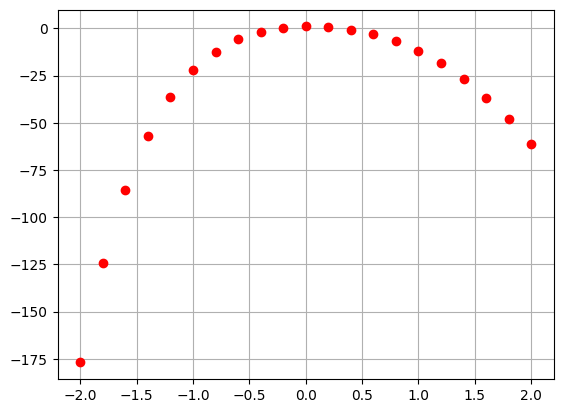

In [22]:

# Cargar el dataset
ruta = '/Users/ferleon/Github/semestre_v/algoritmos_bioinspirados/data/data.xlsx'
df_polar = pl.read_excel(ruta)

df = pl.read_excel(ruta)
x = df['x'].to_numpy()
y = df['y'].to_numpy()
plt.plot(x,y,'ro')
plt.grid()
plt.show()

# FUNCIÓN OBJETIVO

In [23]:
def function(x):
    return x**3 + x**2 + x + 1

# CONJUNTO DE PRIMITIVAS

In [24]:
primitive_set = gp.PrimitiveSet('MAIN', 1) # 1 variable de entrada
primitive_set.addPrimitive(operator.add, 2) # SUMA
primitive_set.addPrimitive(operator.sub, 2) # RESTA
primitive_set.addPrimitive(operator.mul, 2) # MULTIPLICA
primitive_set.addPrimitive(operator.neg, 1)    # NEGACIÓN CAMBIO DE SIGNO
primitive_set.addPrimitive(math.sin, 1)    # SENO
primitive_set.addPrimitive(math.cos, 1)    # COSENO
primitive_set.addEphemeralConstant("rand101", lambda: random.uniform(-1, 1)) # constantes aleatorias entre -1 y 1

# Renombrar variable de entrada
primitive_set.renameArguments(ARG0='x')

# DEFINIR EL TIPO DE FITNESS (minimizar el error)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


# FUNCION PARA INICIALIZAR INDIVIDUOS Y POBLACION
toolbox = base.Toolbox()

toolbox.register('expr', gp.genHalfAndHalf, pset=primitive_set , min_=1, max_=2) # Generar expresiones
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr) # Inicializar individuos
toolbox.register('population', tools.initRepeat, list, toolbox.individual) # Inicializar poblacion


# FUNCION PARA EVALUAR INDIVIDUOS
toolbox.register("compile", gp.compile, pset=primitive_set) # Compilar el individuo

# FUNCION DE EVALUACION
data_points = df_polar['x'].to_list()
valores_objetivo = df_polar['y'].to_list()

def evaluar(individual):
    func = toolbox.compile(expr=individual)
    valores_individuo = [ func(x) for x in data_points ]
    # Calcular el error cuadratico medio
    mse = ((np.array(valores_individuo) - np.array(valores_objetivo))**2).mean()
    return mse,


# MECANISMOS EVOLUTIVOS
toolbox.register("evaluate", evaluar)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=primitive_set)


# SE LIMITA LA PROFUNDIDAD DE LOS INDIVIDUOS
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))


# =================== ALGORITMO EVOLUTIVO ===================
poblacion = toolbox.population(n=300)
hall_of_fame = tools.HallOfFame(1)

# Estadisticas de la evolucion
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)


# Algoritmo evolutivo simple
algorithms.eaSimple(poblacion, toolbox, 0.5, 0.05, 100, stats=stats, halloffame=hall_of_fame, verbose=True)



print("Mejor individuo: ", hall_of_fame[0])
print()



# =================== PARA MEJORAR LA VISUALIZACION DEL INDIVIDUO ===================
x = sympy.symbols('x')


replacements = {
    "add": lambda a,b: a + b,
    "sub": lambda a,b: a - b,
    "mul": lambda a,b: a * b,
    "neg": lambda a: -a,
    "sin": sympy.sin,
    "cos": sympy.cos,
}


expr_str = str(hall_of_fame[0])
expr_sympy = sympy.sympify(expr_str, locals=replacements)

print(f"\nExpresión simbólica: {sympy.simplify(expr_sympy)}")

# Convertir el mejor individuo a una función de Python
func_mejor = toolbox.compile(expr=hall_of_fame[0])
print()



# Comparar con los valores originales
for x,y in zip(data_points, valores_objetivo):
    print(f"x={x:.2f} -> f(x)={y:.4f} | individuo(x)={func_mejor(x):.4f}")



gen	nevals	avg    	std    	min    	max    
0  	300   	3247.22	71.0062	2951.53	3466.47
1  	147   	3207.57	64.1043	2951.53	3461.18
2  	160   	3187.17	73.6923	2894.6 	3609.28
3  	140   	3154.23	83.15  	2894.6 	3455.36
4  	157   	3130.48	102.248	2865.31	3528.27
5  	167   	3137.15	166.042	2865.31	3992.39
6  	145   	3088.36	178.804	2712.89	3992.39
7  	157   	3059.43	233.795	2680.98	4716.4 
8  	136   	3009.43	263.159	2640.78	4664.62
9  	158   	2955.51	248.727	2271.65	4165.84
10 	161   	2928.8 	410.907	810.13 	5926.59
11 	157   	2824.16	496.18 	810.13 	6502.27
12 	152   	2739.11	645.716	810.13 	9798.54
13 	157   	2621.33	706.094	845.869	7113.71
14 	159   	2488.24	887.347	714.472	9039.99
15 	176   	2212.46	825.107	298.628	6695.66
16 	167   	2215.22	2111.3 	101.23 	24629.6
17 	138   	2038.82	3747.42	101.23 	42550.6
18 	173   	3778.17	33647.5	101.23 	580450 
19 	161   	3800.5 	33774.6	59.1889	581903 
20 	173   	2904.15	11575.1	20.5959	133995 
21 	168   	1874.24	4910.6 	18.2574	38595.2
22 	173   	

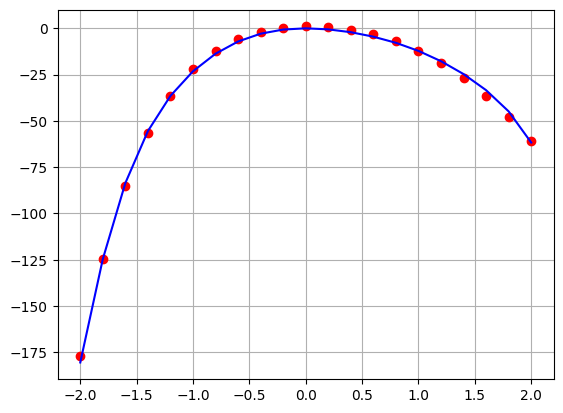

In [25]:




x = df['x'].to_numpy()
y = df['y'].to_numpy()


# Datos aproximados por el mejor individuo
y_aprox = [func_mejor(xi) for xi in x]


plt.plot(x,y,'ro')
plt.plot(x,y_aprox,'b-')
plt.grid()
plt.show()


